In [107]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import tikzplotlib

In [108]:
%run utilities

In [109]:
def ups_logit(odds_and_total_by_district, num_districts, total_voting_population):
    if verbose:
        print(f"Election: {election} ({num_districts} districts)")
        print(f"Percentage voting R: {total_vote_share_for_republicans}")
        print(f"Percentage of seats won by R: {seats_won_by_republicans}")

    # Vary statewide vote share for Republicans to generate UPS curves
    # Approach: 1) sort districts in decreasing order of odds, since districts with largest odds can tolerate
    # the largest swing against R, 2) Figure out the vote share where the odds factor is reciprocal (where
    # the switch happens)

    odds_and_total_by_district.sort(key=get_odds, reverse=True)

    vote_swing_where_seat_flip_happens = [0] * (num_districts + 2)

    for n in range(num_districts):
        
        votes_to_swing_R = 0
        
        for d in range(num_districts):
            odds_in_first_district = odds_and_total_by_district[n][0]
            odds_in_second_district = odds_and_total_by_district[d][0]

            odds_ratio = odds_in_second_district / odds_in_first_district

            total_votes_in_second_district = odds_and_total_by_district[d][1]
            votes_to_swing_R += total_votes_in_second_district * odds_ratio / (odds_ratio + 1)

        vote_swing_where_seat_flip_happens[n + 1] = ceil(votes_to_swing_R / total_voting_population * 100)

    vote_swing_where_seat_flip_happens[num_districts + 1] = 100

    votes = [x / float(100) for x in range(100)]
    seats = [0.0] * 100

    index = vote_swing_where_seat_flip_happens[1]

    for number_of_districts_won in range(1, num_districts + 1):
        while index < vote_swing_where_seat_flip_happens[number_of_districts_won + 1]:
            seats[index] = number_of_districts_won / float(num_districts)
            index += 1    
            
    median_mean_logit = 0.5 - np.median(vote_swing_where_seat_flip_happens) / 100

    return votes, seats, median_mean_logit


def ups_linear(vote_share_by_district):
    num_divisions = 100
    deltas = range(-int(num_divisions/2), int(num_divisions/2), 1)

    seats = []
    votes = []

    for ds in deltas:
        ds = float(ds) / num_divisions
        new_election = np.array(vote_share_by_district) + np.ones(np.shape(vote_share_by_district)) * ds
        new_election[new_election < 0] = 0
        new_election[new_election > 1] = 1
        new_vote = np.mean(new_election)
        new_seats = len(np.where(np.array(new_election) > 0.5)[0]) / len(new_election)
        seats.append(new_seats)
        votes.append(new_vote)

    median_mean_linear = np.median(vote_share_by_district) - np.mean(vote_share_by_district)

    return votes, seats, median_mean_linear


def add_partisan_symmetry(plt,seats_won_by_republicans, total_vote_share_for_republicans, seats, votes):
    symmetric_v = 1 - total_vote_share_for_republicans
    symmetric_s = 1 - seats_won_by_republicans
    s_intersect_symmetric_interp = np.interp(symmetric_v, votes, seats)

    if symmetric_s - s_intersect_symmetric_interp < 0:
        s_intersect_symmetric = np.where(seats - s_intersect_symmetric_interp >= 0, seats, np.inf).min()

    if symmetric_s - s_intersect_symmetric_interp > 0:
        s_intersect_symmetric = np.where(seats - s_intersect_symmetric_interp <= 0, seats, -np.inf).max()

    if symmetric_s == s_intersect_symmetric_interp:
        s_intersect_symmetric = s_intersect_symmetric_interp

    partisan_symmetry_x = [total_vote_share_for_republicans - metric_buffer, total_vote_share_for_republicans + metric_buffer, total_vote_share_for_republicans + metric_buffer,
                           total_vote_share_for_republicans - metric_buffer]
    partisan_symmetry_y = [1-s_intersect_symmetric, 1-s_intersect_symmetric, 1-symmetric_s, 1-symmetric_s]
    plt.fill(partisan_symmetry_x, partisan_symmetry_y, '--', color=partisan_symmetry_color,edgecolor=partisan_symmetry_color, zorder=2)
    return s_intersect_symmetric - symmetric_s
    
def add_mean_median(plt, votes, seats):
    v_intersect = np.interp(0.5, seats, votes)

    mean_median_x = [v_intersect, v_intersect, 0.5, 0.5]
    mean_median_y = [0.5 - metric_buffer, 0.5 + metric_buffer, 0.5 + metric_buffer, 0.5 - metric_buffer]

    plt.fill(mean_median_x, mean_median_y, '--', color=mean_median_color, edgecolor=mean_median_color,
                     zorder=2)


def add_partisan_bias(plt, votes, seats):
    s_intersect = np.interp(0.5, votes, seats)

    bias_x = [0.5 - metric_buffer, 0.5 + metric_buffer, 0.5 + metric_buffer,
                  0.5 - metric_buffer]
    bias_y = [s_intersect, s_intersect, 0.5, 0.5]
        
    plt.fill(bias_x, bias_y, '--', color=bias_color, edgecolor=bias_color, zorder=2)

    
def configure_plot(plt):
    plt.xlim(x_range)
    plt.ylim(y_range)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("Fraction of votes for Republicans", fontname=font_name, fontsize=font_size)
    ax.set_ylabel("Fraction of seats won by Republicans", fontname=font_name, fontsize=font_size)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    save_name_str = plot_settings_to_str(plot_ups, plot_bias, plot_mean_median, plot_partisan_symmetry)
    plt.savefig("outputs/" + election + save_name_str + '.png', dpi=500)

    tikzplotlib.save("outputs/" + election + save_name_str + ".tex")

    plt.show()
    plt.close()


def plot_all_elections_and_make_table():
    print(f'\n\nElection & Partisan bias & Mean-median & Partisan symmetry  & Area between curves \\\\ ')
    for election in all_elections:
        partisan_bias, mean_median, partisan_symmetry, area_between_curves = make_partisan_symmetry_plots(election, plot_parameters)
        print(f'{election} & {round(partisan_bias, 3)} & {round(mean_median, 3)} & {round(partisan_symmetry, 3)} & {round(area_between_curves,3)} \\\\')



    
def make_partisan_symmetry_plots(election, plot_parameters):

    plot_ups = plot_parameters['plot_ups']
    plot_bias = plot_parameters['plot_bias']
    plot_partisan_symmetry = plot_parameters['plot_partisan_symmetry']
    plot_mean_median = plot_parameters['plot_mean_median']

    fig = plt.figure()
    ax = fig.add_subplot(111)

    districts_raw = open('data/' + election + '_districts_R_D.csv').read().split('\n')
    districts_raw = np.array([[float(item) for item in line.split(',')] for line in districts_raw])

    # Get data about the election (votes and seats)
    total_dem_votes = 0
    total_rep_votes = 0
    odds_and_total_by_district = []  

    vote_share_by_district = []
    seats_won_by_republicans = 0

    for i in range(len(districts_raw)):
        republicans_votes_in_district = districts_raw[i][0]
        democrat_votes_in_district = districts_raw[i][1]

        if republicans_votes_in_district + democrat_votes_in_district > 0:  # Ignore empty lines

            total_rep_votes += republicans_votes_in_district
            total_dem_votes += democrat_votes_in_district

            odds_and_total_by_district.append([republicans_votes_in_district / democrat_votes_in_district,
                                               republicans_votes_in_district + democrat_votes_in_district])
            vote_share_by_district.append(
                republicans_votes_in_district / (republicans_votes_in_district + democrat_votes_in_district))

            if republicans_votes_in_district > democrat_votes_in_district:  # If Republicans won the district
                seats_won_by_republicans += 1

    num_districts = len(odds_and_total_by_district)
    total_voting_population = total_dem_votes + total_rep_votes
    total_vote_share_for_republicans = total_rep_votes / float(total_voting_population)
    seats_won_by_republicans = seats_won_by_republicans / float(num_districts)

    votes, seats, mean_median = ups_logit(odds_and_total_by_district, num_districts, total_voting_population)

    # votes, seats, mean_median = ups_linear(vote_share_by_district)

    partisan_bias = seats[50] - 0.5

    plt.plot(x_range, [0.5, 0.5], color=grid_color, linewidth=background_line_width, zorder=-1)
    plt.plot([0.5, 0.5], y_range, color=grid_color, linewidth=background_line_width, zorder=-1)

    if plot_ups:
        plt.step(votes, seats, color=ups_color, linewidth=ups_line_width, zorder=1)

    plt.scatter([total_vote_share_for_republicans], [seats_won_by_republicans], color=actual_color,
                edgecolors=actual_color, zorder=3, s=70)

    if plot_bias:
        add_partisan_bias(plt, votes, seats)

    if plot_mean_median:
        add_mean_median(plt, votes, seats)

    partisan_symmetry = None
    if plot_partisan_symmetry:
        partisan_symmetry = add_partisan_symmetry(plt,seats_won_by_republicans, total_vote_share_for_republicans, seats, votes)

    if not plot_ups:
        plt.plot(x_range, y_range, '--', color=grid_color, linewidth=background_line_width, zorder=0)

    area_between_curves = None
    if plot_partisan_symmetry:
        area_between_curves = flip_and_plot_partisan_symmetry(votes, seats)
    
    return partisan_bias, mean_median, partisan_symmetry, area_between_curves



def get_odds(odds_pop_pair):
    return odds_pop_pair[0]


def flip_and_plot_partisan_symmetry(votes, seats):
    reversed_votes = np.concatenate((np.flip(1 - np.array(votes[:-1])), np.array([1])))
    reversed_seats = np.flip(1 - np.array(seats[:]))

    plt.step(reversed_votes, reversed_seats, color=ups_color_reversed, linewidth=ups_line_width, zorder=1)
    cumulative_sum = 0
    for i in range(len(reversed_votes) - 2):
        x = [reversed_votes[i], reversed_votes[i], votes[i+1], votes[i+1]]
        y = [reversed_seats[i], seats[i+2], seats[i+2], reversed_seats[i]]
        plt.fill(x, y, facecolor=ups_color_shaded)
        if 0.4 <= votes[i + 1] <= 0.6:

            area = fabs(reversed_votes[i] - votes[i+1])*fabs(reversed_seats[i] - seats[i+2])

            # This is signed 
            if reversed_seats[i] <= seats[i+2]:
                cumulative_sum = cumulative_sum + area
            else:
                cumulative_sum = cumulative_sum - area

    plt.xlim(x_range)
    plt.ylim(y_range)

    return cumulative_sum


In [110]:
all_elections = ["IN_2016", "MD_2016", "MI_2016", "MN_2016", "MO_2016", "NJ_2016", "OH_2016"]

x_buff = 0.05
y_buff = 0.05
metric_buffer = 0.008

x_range = [-x_buff, 1 + x_buff]
y_range = [-y_buff, 1 + y_buff]
font_name = 'Helvetica'
font_size = 15
verbose = False

(0.16666666666666663, 0.03999999999999998, None, None)

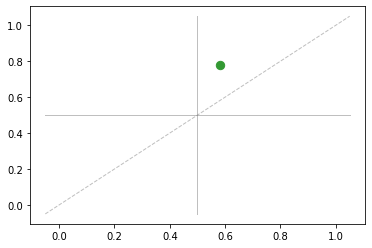

In [111]:
election = "IN_2016"
plot_parameters = {'plot_ups': False, 'plot_bias': False, 'plot_partisan_symmetry': False, 'plot_mean_median': False}
make_partisan_symmetry_plots(election, plot_parameters)


(0.16666666666666663, 0.03999999999999998, None, None)

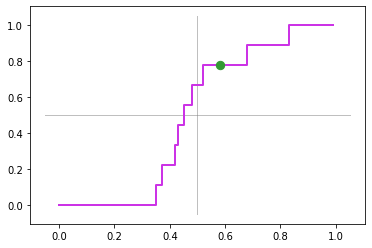

In [112]:
plot_parameters = {'plot_ups': True, 'plot_bias': False, 'plot_partisan_symmetry': False, 'plot_mean_median': False}
make_partisan_symmetry_plots(election, plot_parameters)

(0.16666666666666663, 0.03999999999999998, 0.0, 0.044444444444444425)

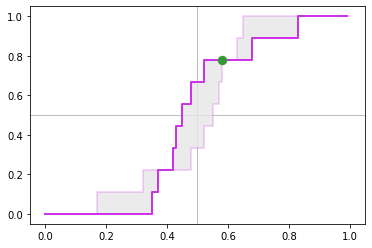

In [113]:

plot_parameters = {'plot_ups': True, 'plot_bias': False, 'plot_partisan_symmetry': True, 'plot_mean_median': False}
make_partisan_symmetry_plots(election, plot_parameters)


(0.16666666666666663, 0.03999999999999998, 0.0, 0.044444444444444425)

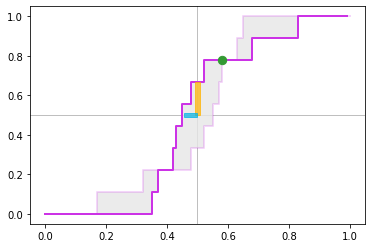

In [114]:
plot_parameters = {'plot_ups': True, 'plot_bias': True, 'plot_partisan_symmetry': True, 'plot_mean_median': True}
make_partisan_symmetry_plots(election, plot_parameters)
